## Predict the employee attrition rate in organizations

### ABOUT CHALLENGE

### Problem statement

Employees certainly are the most important asset of an organization. They are the ones working behind the scenes to ensure that your business functions seamlessly like a well-oiled machine. Hiring the best fit for an organization and ensuring that they stick with the company are two sides of the same coin. Employee attrition not only may lead to a minor hitch in the system, but it is also a major cost to the organization.

The Human Resources department of your organization is determined to predict the employee attrition rate in advance and put a corrective plan of action in place. As a Machine Learning Specialist, the HR team has requested you to build a sophisticated model that predicts the organization’s attrition rate.

### Dataset

The dataset consists of various details such as gender and age of the employee, education and relationship status, pay scale, and other factors that may influence the attrition rate.

The benefits of practicing this problem by using Machine Learning techniques are as follows:

- This challenge will encourage you to apply your Machine Learning skills to build models that can predict employee attrition rates.
- This challenge will help you enhance your knowledge of regression. Regression is one of the basic building blocks of Machine Learning.
We challenge you to build a model that computes the attrition rate for an employee working in an organization.

- Train.csv
- Test.csv
- sample_submission.csv

### Data Description

- __Employee_ID__:	Unique ID of each employee
- __Age__:	Age of each employee
- __Unit__:	Department under which the employee work
- __Education__:	Rating of Qualification of an employee (1-5)
- __Gender__	Male-0 or Female-1
- __Decision_skill_possess__	Decision skill that an employee possesses
- __Post_Level__	Level of the post in an organization (1-5)
- __Relationship_Status__	Categorical Married or Single 
- __Pay_Scale__	Rate in between 1 to 10
- __Time_of_service__	Years in the organization
- __growth_rate__	Growth rate in percentage of an employee
- __Time_since_promotion__	Time in years since the last promotion
- __Work_Life_balance__	Rating for work-life balance given by an employee.
- __Travel_Rate__	Rating based on travel history(1-3)
- __Hometown__	Name of the city
- __Compensation_and_Benefits__	Categorical Variabe
- __VAR1 - VAR5__	Anominised variables
- __Attrition_rate(TARGET VARIABLE)__	Attrition rate of each employee

### Submission format
You are required to write your predictions in a .csv file that contain the following columns:

Employee_ID

Attrition_rate

### Evaluation criteria
The evaluation metric that is used for this problem is the root mean squared error. The formula is as follows:
 
 score = 100 * max(0,1 - root_mean_squared_error(actual_values,predicted_values))

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost
import csv as csv
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score,KFold,train_test_split,GridSearchCV 
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from scipy.stats import skew
from collections import OrderedDict

In [2]:
#Importing the dataset
train = pd.read_csv('./Dataset/Train.csv')
pd.set_option('display.max_columns', None)
train_data = train
train_data.shape
train_data.set_index('Employee_ID',inplace= True)
print(train.columns)
print(train.head())

Index(['Gender', 'Age', 'Education_Level', 'Relationship_Status', 'Hometown',
       'Unit', 'Decision_skill_possess', 'Time_of_service',
       'Time_since_promotion', 'growth_rate', 'Travel_Rate', 'Post_Level',
       'Pay_Scale', 'Compensation_and_Benefits', 'Work_Life_balance', 'VAR1',
       'VAR2', 'VAR3', 'VAR4', 'VAR5', 'VAR6', 'VAR7', 'Attrition_rate'],
      dtype='object')
            Gender   Age  Education_Level Relationship_Status     Hometown  \
Employee_ID                                                                  
EID_23371        F  42.0                4             Married     Franklin   
EID_18000        M  24.0                3              Single  Springfield   
EID_3891         F  58.0                3             Married      Clinton   
EID_17492        F  26.0                3              Single      Lebanon   
EID_22534        F  31.0                1             Married  Springfield   

                                  Unit Decision_skill_possess  \
E

In [3]:
#Read the test datasets
test = pd.read_csv('./Dataset/Test.csv')
pd.set_option('display.max_columns', None)
test_data = test
test_data.shape
test_data.set_index('Employee_ID',inplace= True)
#Creating a fake value for attrition_rate
test_data['Attrition_rate'] = 0
print(test.columns)
print(test.head())

Index(['Gender', 'Age', 'Education_Level', 'Relationship_Status', 'Hometown',
       'Unit', 'Decision_skill_possess', 'Time_of_service',
       'Time_since_promotion', 'growth_rate', 'Travel_Rate', 'Post_Level',
       'Pay_Scale', 'Compensation_and_Benefits', 'Work_Life_balance', 'VAR1',
       'VAR2', 'VAR3', 'VAR4', 'VAR5', 'VAR6', 'VAR7', 'Attrition_rate'],
      dtype='object')
            Gender   Age  Education_Level Relationship_Status     Hometown  \
Employee_ID                                                                  
EID_22713        F  32.0                5              Single  Springfield   
EID_9658         M  65.0                2              Single      Lebanon   
EID_22203        M  52.0                3             Married  Springfield   
EID_7652         M  50.0                5              Single   Washington   
EID_6516         F  44.0                3             Married     Franklin   

                  Unit Decision_skill_possess  Time_of_service  \


In [4]:
##Merging the train and test dataset
complete = pd.concat([train_data,test_data])
complete.shape

(10000, 23)

In [5]:
complete['Gender'].describe()

count     10000
unique        2
top           F
freq       5842
Name: Gender, dtype: object

In [6]:
print(complete['Age'].isnull().sum()) #There are 573 missing values in Age column
complete['Age'].describe()

573


count    9427.000000
mean       39.675507
std        13.574856
min        19.000000
25%        27.000000
50%        38.000000
75%        52.000000
max        65.000000
Name: Age, dtype: float64

In [7]:
#Instead of Age let us consider Age_band based on the above output
def findBand(Age):
    if Age <=27:
        return 1
    elif Age>27 and Age<=38:
        return 2
    elif Age>38 and Age<=52:
        return 3
    else:
        return 4
    
complete['band'] = complete['Age'].apply(findBand)

In [8]:
print(complete['Education_Level'].isnull().sum()) #There are 573 missing values in Age column
complete['Education_Level'].describe()

0


count    10000.000000
mean         3.199400
std          1.065436
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: Education_Level, dtype: float64

In [9]:
print(complete['Relationship_Status'].isnull().sum()) #There are no missing values in Relationship_Status column
complete['Relationship_Status'].describe()

0


count       10000
unique          2
top       Married
freq         6461
Name: Relationship_Status, dtype: object

In [10]:
print(complete['Relationship_Status'].isnull().sum()) #There are no missing values in Relationship_Status column
complete['Relationship_Status'].describe()

0


count       10000
unique          2
top       Married
freq         6461
Name: Relationship_Status, dtype: object

In [11]:
print(complete['Hometown'].isnull().sum()) #There are no missing values in Relationship_Status column
complete['Hometown'].describe()

0


count       10000
unique          5
top       Lebanon
freq         2953
Name: Hometown, dtype: object

In [12]:
print(complete['Unit'].isnull().sum()) #There are no missing values in Relationship_Status column
complete['Unit'].describe()

0


count     10000
unique       12
top          IT
freq       1963
Name: Unit, dtype: object

In [13]:
print(complete['Decision_skill_possess'].isnull().sum())
complete['Decision_skill_possess'].describe()

0


count          10000
unique             4
top       Behavioral
freq            2535
Name: Decision_skill_possess, dtype: object

In [14]:
print(complete['Time_of_service'].isnull().sum()) #There are 196 missing values
complete['Time_of_service'].describe()
complete['Time_of_service'].fillna((complete['Time_of_service'].mean()), inplace=True)
print(complete['Time_of_service'].isnull().sum())

196
0


In [15]:
print('Missing values:',complete['Time_since_promotion'].isnull().sum()) #There are 196 missing values
complete['Time_since_promotion'].describe()

Missing values: 0


count    10000.00000
mean         2.37860
std          1.14978
min          0.00000
25%          1.00000
50%          2.00000
75%          3.00000
max          4.00000
Name: Time_since_promotion, dtype: float64

In [16]:
print('Missing values:',complete['growth_rate'].isnull().sum()) #There are 196 missing values
complete['growth_rate'].describe()

Missing values: 0


count    10000.000000
mean        47.008400
std         15.848553
min         20.000000
25%         33.000000
50%         47.000000
75%         61.000000
max         74.000000
Name: growth_rate, dtype: float64

In [17]:
print('Missing values:',complete['Travel_Rate'].isnull().sum()) #There are 196 missing values
complete['Travel_Rate'].describe()

Missing values: 0


count    10000.000000
mean         0.820700
std          0.646524
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: Travel_Rate, dtype: float64

In [18]:
print('Missing values:',complete['Post_Level'].isnull().sum()) #There are 196 missing values
complete['Post_Level'].describe()

Missing values: 0


count    10000.000000
mean         2.797000
std          1.171037
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: Post_Level, dtype: float64

In [19]:
print('Missing values:',complete['Pay_Scale'].isnull().sum()) #There are 196 missing values
print(complete['Pay_Scale'].describe())
complete['Pay_Scale'].fillna(6.0, inplace=True) #Replacing with most common value

Missing values: 12
count    9988.000000
mean        6.022627
std         2.070087
min         1.000000
25%         5.000000
50%         6.000000
75%         8.000000
max        10.000000
Name: Pay_Scale, dtype: float64


In [20]:
print('Missing values:',complete['Compensation_and_Benefits'].isnull().sum()) #There are 0 missing values
complete['Compensation_and_Benefits'].describe()

Missing values: 0


count     10000
unique        5
top       type2
freq       5686
Name: Compensation_and_Benefits, dtype: object

In [21]:
print('Missing values:',complete['Work_Life_balance'].isnull().sum()) #There are 16 missing values
complete['Work_Life_balance'].describe()
complete['Work_Life_balance'].fillna(2.0, inplace=True) #Replacing with most common value

Missing values: 16


In [22]:
print('Missing values:',complete['VAR1'].isnull().sum()) #There are 0 missing values
complete['VAR1'].describe()

Missing values: 0


count    10000.000000
mean         3.089100
std          0.831884
min          1.000000
25%          3.000000
50%          3.000000
75%          3.000000
max          5.000000
Name: VAR1, dtype: float64

Missing values: 794


C:\Users\kanum\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\kanum\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


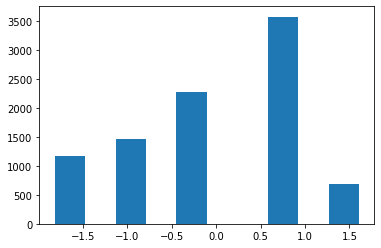

In [23]:
print('Missing values:',complete['VAR2'].isnull().sum()) #There are 794 missing values
complete['VAR2'].describe()
plt.hist(complete['VAR2'])
complete['VAR2'].fillna(0.002653, inplace=True) #Replacing with most common value

Missing values: 954
count    9046.000000
mean        1.895976
std         0.533987
min         1.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: VAR4, dtype: float64


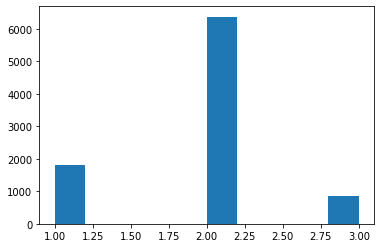

In [24]:
print('Missing values:',complete['VAR4'].isnull().sum()) #There are 954 missing values
print(complete['VAR4'].describe())
plt.hist(complete['VAR4'])
complete['VAR4'].fillna(1.895976, inplace=True) #Replacing with most common value

In [25]:
##One hot encoding
complete = pd.get_dummies(complete,columns = ['Gender','Relationship_Status', 'Hometown', 'Unit', 'Decision_skill_possess','Compensation_and_Benefits'],prefix =['Gender','Relationship_Status', 'Hometown', 'Unit', 'Decision_skill_possess','Compensation_and_Benefits'])
complete = complete.drop(['Age'],1)

In [26]:
complete.head(5)

,Education_Level,Time_of_service,Time_since_promotion,growth_rate,Travel_Rate,Post_Level,Pay_Scale,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,Attrition_rate,band,Gender_F,Gender_M,Relationship_Status_Married,Relationship_Status_Single,Hometown_Clinton,Hometown_Franklin,Hometown_Lebanon,Hometown_Springfield,Hometown_Washington,Unit_Accounting and Finance,Unit_Human Resource Management,Unit_IT,Unit_Logistics,Unit_Marketing,Unit_Operarions,Unit_Production,Unit_Purchasing,Unit_Quality,Unit_R&D,Unit_Sales,Unit_Security,Decision_skill_possess_Analytical,Decision_skill_possess_Behavioral,Decision_skill_possess_Conceptual,Decision_skill_possess_Directive,Compensation_and_Benefits_type0,Compensation_and_Benefits_type1,Compensation_and_Benefits_type2,Compensation_and_Benefits_type3,Compensation_and_Benefits_type4
Employee_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
EID_23371,4,4.0,4,33,1,1,7.0,3.0,4,0.7516,1.8688,2.000000,4,5,3,0.1841,3,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
EID_18000,3,5.0,4,36,0,3,6.0,4.0,3,-0.9612,-0.4537,2.000000,3,5,3,0.0670,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
EID_3891,3,27.0,3,51,0,2,8.0,1.0,4,-0.9612,-0.4537,3.000000,3,8,3,0.0851,4,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
EID_17492,3,4.0,3,56,1,3,8.0,1.0,3,-1.8176,-0.4537,1.895976,3,7,3,0.0668,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
EID_22534,1,5.0,4,62,1,3,2.0,3.0,1,0.7516,-0.4537,2.000000,2,8,2,0.1827,2,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [27]:
Test_data = complete[7000:]
train_data = complete[0:7000]

In [31]:
train_data.head()

,Education_Level,Time_of_service,Time_since_promotion,growth_rate,Travel_Rate,Post_Level,Pay_Scale,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,Attrition_rate,band,Gender_F,Gender_M,Relationship_Status_Married,Relationship_Status_Single,Hometown_Clinton,Hometown_Franklin,Hometown_Lebanon,Hometown_Springfield,Hometown_Washington,Unit_Accounting and Finance,Unit_Human Resource Management,Unit_IT,Unit_Logistics,Unit_Marketing,Unit_Operarions,Unit_Production,Unit_Purchasing,Unit_Quality,Unit_R&D,Unit_Sales,Unit_Security,Decision_skill_possess_Analytical,Decision_skill_possess_Behavioral,Decision_skill_possess_Conceptual,Decision_skill_possess_Directive,Compensation_and_Benefits_type0,Compensation_and_Benefits_type1,Compensation_and_Benefits_type2,Compensation_and_Benefits_type3,Compensation_and_Benefits_type4
Employee_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
EID_23371,4,4.0,4,33,1,1,7.0,3.0,4,0.7516,1.8688,2.000000,4,5,3,0.1841,3,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
EID_18000,3,5.0,4,36,0,3,6.0,4.0,3,-0.9612,-0.4537,2.000000,3,5,3,0.0670,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
EID_3891,3,27.0,3,51,0,2,8.0,1.0,4,-0.9612,-0.4537,3.000000,3,8,3,0.0851,4,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
EID_17492,3,4.0,3,56,1,3,8.0,1.0,3,-1.8176,-0.4537,1.895976,3,7,3,0.0668,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
EID_22534,1,5.0,4,62,1,3,2.0,3.0,1,0.7516,-0.4537,2.000000,2,8,2,0.1827,2,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [49]:
#Looking for most relevant features
#Intializing the model
model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.1,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

In [34]:
X= train_data.drop('Attrition_rate',1)
y = train_data.Attrition_rate
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5250, 46)
(5250,)
(1750, 46)
(1750,)


In [50]:
model.fit(X_train, y_train)

C:\Users\kanum\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:31:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1.5, missing=None,
             n_estimators=10000, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0.75, reg_lambda=0.45,
             scale_pos_weight=1, seed=42, silent=None, subsample=0.6,
             verbosity=1)

In [51]:
y_pred = model.predict(X_test)

In [52]:
from sklearn.metrics import mean_squared_error
def score(y_test,y_pred):
    return 100*max(0,1-mean_squared_error(y_test,y_pred))

In [53]:
score(y_test,y_pred)

95.47181451616879

In [54]:
test_data = Test_data.drop('Attrition_rate',1)
test_predict = model.predict(test_data)
test_predict.shape
test_predict

array([0.18663475, 0.29879946, 0.40124175, ..., 0.148049  , 0.08715537,
       0.11978972], dtype=float32)

In [55]:
test = pd.read_csv('./Dataset/Test.csv')

In [56]:
submission=pd.DataFrame(test_predict, columns=['Attrition_rate']) 
submission['Employee_ID']= test['Employee_ID']
submission.head(2)
pd.DataFrame(submission,columns = ['Employee_ID','Attrition_rate']).to_csv('xgb.csv',index = False)